# Statistical Analysis of Polygon characteristics across a stream in McMurdo Dry Valleys
**Methods:** 
 - Divide mapped region into grid
 - Calculate common statistics for Polygons within each grid cell
 - Calculate intersection style and angles within each grid cell
 - Create 1000 random Voronoi meshes with same amount of Polygons in them for each cell
    - Calculate average nearest neighbour (ANN) distance of Polygon centroids (-> Polygon size)
    - ANN distance of intersections
    - intersection angle distribution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import AffineTransformer
import geopandas as gpd
import pandas as pd
from apdt.stats import calculate_intersection_angles
from apdt.pre_processing import import_raw_dem
import shapely.geometry as geom

In [5]:
def transform_geometry(geometry,transformer):
    def trans_it(x,y):
        yt,xt = transformer.rowcol(xs=x,ys=y)
        points = list(zip(xt,yt))
        return points


    if type(geometry) == geom.polygon.Polygon:
        x,y = geometry.boundary.coords.xy
        trans_geometry = geom.Polygon(trans_it(x,y))
    elif type(geometry) == geom.linestring.LineString:
        x,y = geometry.coords.xy
        trans_geometry = geom.LineString(trans_it(x,y))
    elif type(geometry) == geom.point.Point:
        x,y = geometry.coords.xy
        trans_geometry = geom.Point(trans_it(x,y))
    
    return trans_geometry

In [6]:
# Load in DEM and mapped Polygons
dem_path = 'DEMs/70-81_clipStream.tif'
poly_path = 'Outputs/Stream/70-81_clipStream_Polygons_manualedits'

dem, trans_mat, crs = import_raw_dem(dem_path)
transformer = AffineTransformer(trans_mat)

poly_gdf = gpd.read_file(poly_path)
poly_list = [transform_geometry(p,transformer) for p in poly_gdf['geometry']]

the minimum raster value:  321.2753
the maximum raster value:  417.9084
0.5th percentile:  324.41666229248045
1st percentile:  325.4610653686523
5th percentile:  328.31048583984375
50th percentile:  342.9844055175781
75th percentile:  355.631591796875
90th percentile:  370.5914642333984
95th percentile:  381.4447937011719
99.99th percentile:  416.64740344543435
99.991th percentile:  416.68496138244626
99.995th percentile:  416.72032447021485
99.999th percentile:  417.4212129251098


In [7]:
len(poly_list)

2967

In [8]:
trough_gdf = gpd.read_file('Outputs/Stream/70-81_clipStream_trouhgs_manualedits')
trough_list = [transform_geometry(p,transformer) for p in trough_gdf['geometry']]

node_gdf = gpd.read_file('Outputs/Stream/70-81_clipStream_nodes_manualedits')
node_list = [transform_geometry(n,transformer) for n in node_gdf['geometry']]

# recreate edges list for graphing:
edges = []
for trough in trough_list:
    x,y = trough.xy
    start = geom.Point((x[0],y[0]))
    stop = geom.Point((x[-1],y[-1]))
    edges.append({'start':start,'stop':stop,'path':trough})


## Divide into Grid
Divide the DEM into a grid of 128 sections to calculate statistics over

In [9]:
# set grid size:
rows = 16
cols = 8
ny, nx = dem.shape
dy = ny/cols
dx = nx/rows

# get boundaries of grid cells
grid_x = [round(i*dx) for i in range(0,rows+1)]
grid_y = [round(i*dy) for i in range(0,cols+1)]

boxes = []
for i in range(0,len(grid_y)-1):
    y_min = grid_y[i]
    y_max = grid_y[i+1]
    for j in range(0,len(grid_x)-1):
        x_min = grid_x[j]
        x_max = grid_x[j+1]

        boxes.append(geom.Polygon([(x_min,y_min),(x_min,y_max),(x_max,y_max),(x_max,y_min)]))


In [10]:
grid_df = pd.DataFrame(columns=['box','polygons','intersections', 'edges'])

for b in boxes:
    polygons = [p for p in poly_list if (p.overlaps(b)) or p.within(b)]
    intersections = [n for n in node_list if n.within(b)]
    row = pd.Series({'box':b,'polygons':polygons,'intersections':intersections})
    grid_df = pd.concat([row,grid_df], axis=1, ignore_index=True)

grid_df = grid_df.transpose().dropna()

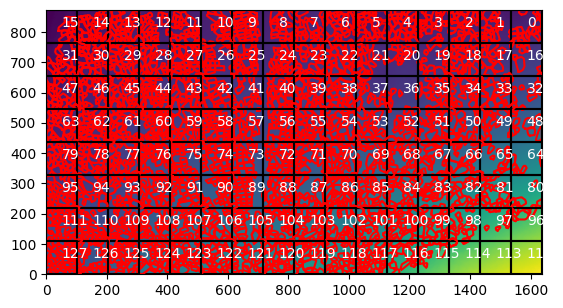

In [11]:
plt.imshow(dem)

for idx, row in grid_df.iterrows():
    for p in row['polygons']:
        x,y = p.boundary.coords.xy
        plt.plot(x,y,c='red')
    x,y = row['box'].boundary.coords.xy
    plt.plot(x,y,c='black')
    xc,yc = row['box'].centroid.coords.xy
    plt.text(xc[0],yc[0],idx,c='white')

plt.xlim(0,nx)
plt.ylim(0,ny);

## Size & Shape
Calculate Area, size, Length/Width, Aspect Ratio

In [12]:
def cart_distance(x1,x2,y1,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def calculate_stats(polygons):
    df = pd.DataFrame(columns=['Area_m2','Width_m','Length_m','Aspect_Ratio','Size_m','Perimeter_m','Thickness_ratio'])
    for p in polygons:
        A = p.area #Area in m2
        s = np.sqrt(4*A/np.pi) #Size in m
        per = p.boundary.length
        bbox = p.minimum_rotated_rectangle
        x_coord = bbox.boundary.coords.xy[0][:4] 
        y_coord = bbox.boundary.coords.xy[1][:4]
        thick = A/bbox.area

        l_edge = [cart_distance(x_coord[0],x_coord[1],y_coord[0],y_coord[1]),cart_distance(x_coord[1],x_coord[2],y_coord[1],y_coord[2])] # bounding box edge lenghts in metres

        if l_edge[0] > l_edge[1]:
            l = l_edge[0]
            w = l_edge[1]
        else:
            l = l_edge[1]
            w = l_edge[0]
        aspect = l/w

        # adding results to new row:
        new_row = {'Area_m2':A,'Width_m':w,'Length_m':l,'Aspect_Ratio':aspect,'Size_m':s,'Perimeter_m':per,'Thickness_ratio':thick}
        df = pd.concat([df,pd.DataFrame.from_records([new_row])], ignore_index=True)
    return df

In [13]:
stats = {}
for idx, row in grid_df.iterrows():
    df = calculate_stats(row['polygons'])
    stats[idx] = df

In [14]:
means_df = pd.DataFrame(columns=['Area_m2','Width_m','Length_m','Aspect_Ratio','Size_m','Perimeter_m','Thickness_ratio'],index=grid_df.index) #store Area, Width, Length, Aspect ratio, Size, Perimeter
for idx in stats:
    df = stats[idx]
    A,W,L,asp,S,per,thick = df.mean()
    means_df.loc[idx] = {'Area_m2':A,'Width_m':W,'Length_m':L,'Aspect_Ratio':asp,'Size_m':S,'Perimeter_m':per,'Thickness_ratio':thick}

means_df = means_df.astype('float')


In [15]:
def stat_array(stat, out_arr):
    for i in grid_df.index:
        xmin,ymin,xmax,ymax = grid_df.loc[i]['box'].bounds
        out_arr[int(ymin):int(ymax),int(xmin):int(xmax)] = means_df.loc[i][stat]
    return out_arr

In [16]:
A_arr = np.zeros_like(dem)
A_arr = stat_array('Area_m2',A_arr)

W_arr = np.zeros_like(dem)
W_arr = stat_array('Width_m',W_arr)

L_arr = np.zeros_like(dem)
L_arr = stat_array('Length_m',L_arr)

asp_arr = np.zeros_like(dem)
asp_arr = stat_array('Aspect_Ratio',asp_arr)

S_arr = np.zeros_like(dem)
S_arr = stat_array('Size_m',S_arr)

per_arr = np.zeros_like(dem)
per_arr = stat_array('Perimeter_m',per_arr)

thick_arr = np.zeros_like(dem)
thick_arr = stat_array('Thickness_ratio',thick_arr)

In [17]:
def plot_statarray(stat_arr):
    fig, ax = plt.subplots(1,1, figsize=(6,8),layout='tight')
    im = ax.imshow(stat_arr,cmap='inferno',origin='lower')
    fig.colorbar(im,location='bottom',pad=0.05)
    return fig, ax

In [18]:
stream = gpd.read_file('Outputs/Stream/StreamMask.shp')
stream = stream['geometry'][0]
stream = transform_geometry(stream,transformer)


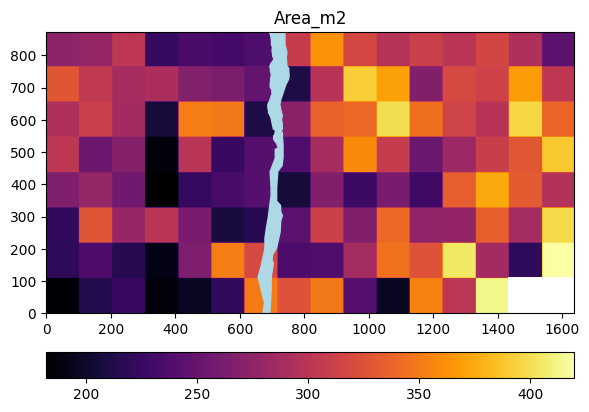

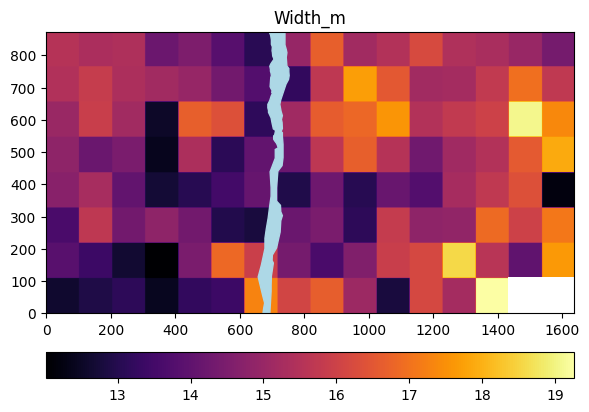

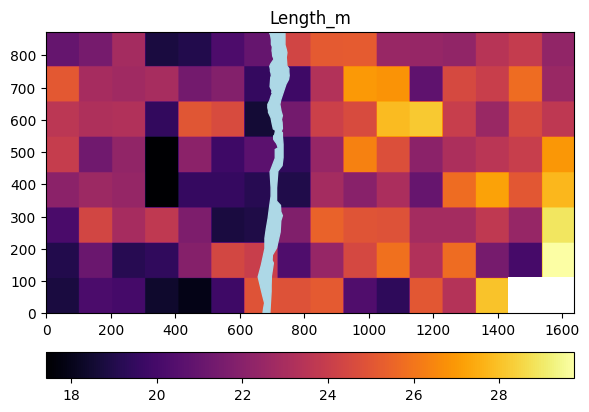

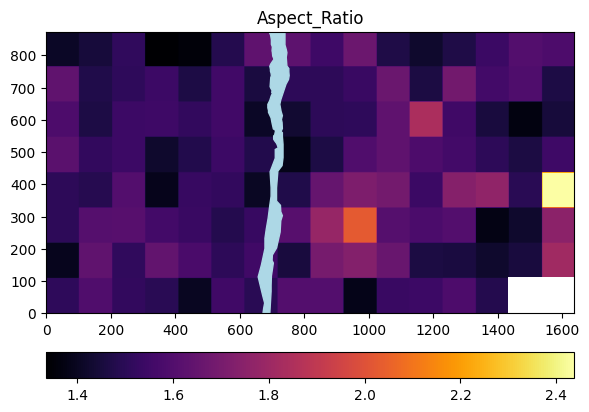

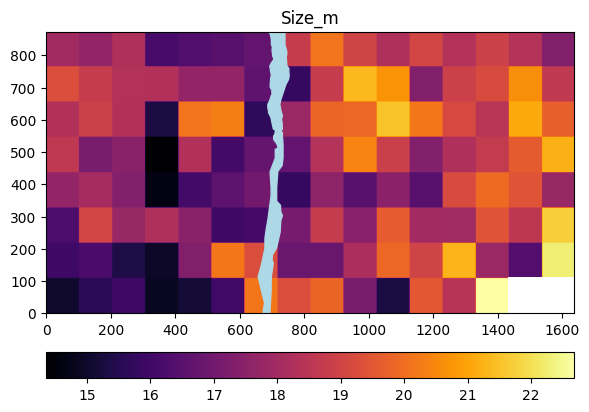

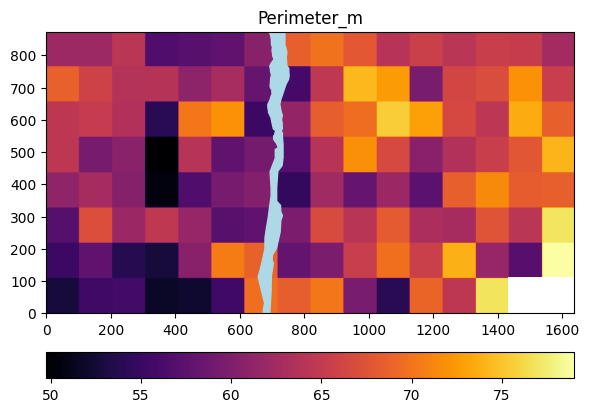

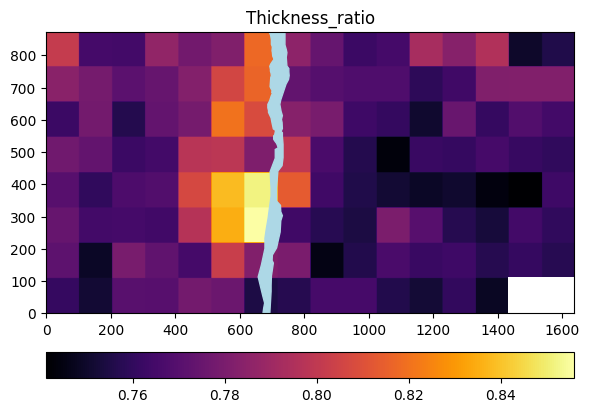

In [36]:
array_list = [A_arr,W_arr,L_arr,asp_arr,S_arr,per_arr,thick_arr]
for i in range(len(array_list)):
    fig, ax = plot_statarray(array_list[i])
    x,y = stream.boundary.coords.xy
    ax.fill(x,y,c='lightblue')
    ax.set_ylim(0,dem.shape[0])
    ax.set_title(means_df.columns[i])
    fig.savefig('FIGURES/segmented_'+means_df.columns[i])

## Intersection Angles
Calculate Intersection Angles, number of triple and quadruple junctions. 

Binned mode angle of each cell? Expectation: near 90 nearby to stream and 120 away

In [19]:
import networkx as nx

In [20]:
min_distance = 1

graph = nx.Graph()
for edge in edges:
    start = (edge['start'].coords.xy[0][0],edge['start'].coords.xy[1][0])
    stop = (edge['stop'].coords.xy[0][0],edge['stop'].coords.xy[1][0])
    graph.add_edge(start,stop,path=edge['path'],length=edge['path'].length)

#Find and remove too short paths:
new_graph = graph #copy graph
for edge in graph.edges:
    n1 = edge[0]
    n2 = edge[1]
    l = graph.get_edge_data(n1,n2)['length'] #get length of edge
    if l < min_distance: #minimum length in number of pixels
        try:
            new_graph.remove_edge(n1,n2)
            new_graph = nx.contracted_nodes(new_graph,n1,n2)
        except:
            print('Edge %s to %s not found. Skipping...' %(n1,n2))


In [21]:
def construct_edge_vectors(node,graph):
    '''
    Function to construct vectors for all edges intersecting at a given node.
    '''
 
    edge_vectors = []
    for e in graph.edges(node):
        base = e[0]
        tip = e[1]
        edge_vectors.append((tip[0]-base[0],tip[1]-base[1])) #construct vector and normalise
    return edge_vectors


In [22]:
intersection_angles = []
for n in new_graph.nodes():
    edge_vectors = construct_edge_vectors(n,new_graph)
    if len(edge_vectors) >2:
        edge_angles = calculate_intersection_angles(edge_vectors)
        for i in edge_angles:
            intersection_angles.append(i)

print('Mean Intersection Angle: %.1f\u00b0' %(np.mean(intersection_angles)))

Mean Intersection Angle: 116.6°


In [23]:
tr = 0
qu = 0
terminal = 0
other = 0

for n in new_graph.nodes:
    num = len(new_graph.edges(n))
    if num == 1:
        terminal +=1
    elif num == 3:
        tr +=1
    elif num ==4:
        qu +=1
    else:
        other +=1
print(tr,qu,terminal,other)

4947 429 170 29


In [24]:
intersection_df = pd.DataFrame(index=grid_df.index, columns=['nodes','angles','junction_num'])
for idx, row in grid_df.iterrows():
    nodes = []
    for n in row['intersections']:
        x,y = n.coords.xy
        nodes.append((x[0],y[0]))
    
    junction_num = []
    intersection_angles = []
    for n in nodes:
        e_list = new_graph.edges(n)
        junction_num.append(len(e_list)) #nuber of edges at a junction 
        edge_vectors = construct_edge_vectors(n,new_graph)
        if len(edge_vectors) >2:
            edge_angles = calculate_intersection_angles(edge_vectors)
            for i in edge_angles:
                intersection_angles.append(i)
    
    intersection_df.loc[idx] = {'nodes':nodes,'angles': intersection_angles, 'junction_num': junction_num}



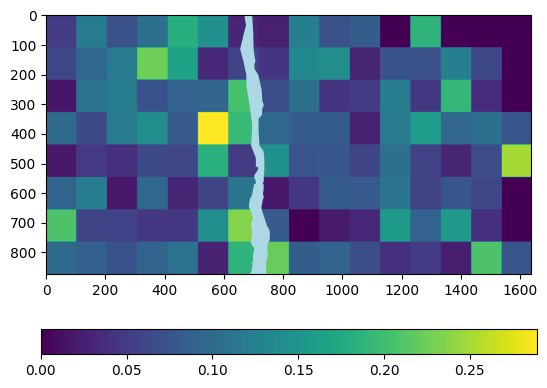

In [25]:
ratio_arr = np.zeros_like(dem)
for idx, row in intersection_df.iterrows():
    jnctn_arr = np.array(row['junction_num'])
    jnctn_ratio = np.sum(jnctn_arr == 4)/np.sum(jnctn_arr == 3)
    xmin,ymin,xmax,ymax = grid_df.loc[idx]['box'].bounds
    ratio_arr[int(ymin):int(ymax),int(xmin):int(xmax)] = jnctn_ratio

x,y = stream.boundary.coords.xy
plt.fill(x,y,color='lightblue')

plt.imshow(ratio_arr,origin='upper')
plt.colorbar(location='bottom')
plt.ylim(dem.shape[0]);
    

Load in Polygons of where orthogonal Polygons are observed

In [24]:
gdf = gpd.read_file('OrthogonalPolygons')
observed_orthogonal = []
for p in gdf['geometry']:
    observed_orthogonal.append(transform_geometry(p,transformer))

In [25]:
orth_polygons_df = pd.DataFrame(columns=['orthogonal','polygons','intersections'])

remaining_polygons = poly_list.copy()
remaining_intersections = node_list.copy()

for b in observed_orthogonal:
    polygons = [p for p in poly_list if (p.overlaps(b)) or p.within(b)]
    intersections = [n for n in node_list if n.within(b)]
    row = pd.Series({'orthogonal':True,'polygons':polygons,'intersections':intersections})
    orth_polygons_df = pd.concat([row,orth_polygons_df], axis=1, ignore_index=True)

orth_polygons_df = orth_polygons_df.transpose().dropna()

orth_polygons_df

,orthogonal,polygons,intersections
0,True,"[POLYGON ((604 80, 621 94, 626 102, 626 106, 6...","[POINT (628 111), POINT (631 117), POINT (604 ..."
1,True,"[POLYGON ((637 636, 648 636, 656 639, 648 671,...","[POINT (662 628), POINT (709 642), POINT (700 ..."


In [26]:
# calculate angles in orthogonal polygon regions
ortho_intersection_df = pd.DataFrame(index=orth_polygons_df.index, columns=['nodes','angles','junction_num'])
for idx, row in orth_polygons_df.iterrows():
    nodes = []
    for n in row['intersections']:
        x,y = n.coords.xy
        nodes.append((x[0],y[0]))
    
    junction_num = []
    intersection_angles = []
    for n in nodes:
        e_list = new_graph.edges(n)
        junction_num.append(len(e_list)) #nuber of edges at a junction 
        edge_vectors = construct_edge_vectors(n,new_graph)
        if len(edge_vectors) >2:
            edge_angles = calculate_intersection_angles(edge_vectors)
            for i in edge_angles:
                intersection_angles.append(i)
    
    ortho_intersection_df.loc[idx] = {'nodes':nodes,'angles': intersection_angles, 'junction_num': junction_num}

# calculate angles for whole field
intersection_angles = []
for n in new_graph.nodes():
    edge_vectors = construct_edge_vectors(n,graph)
    if len(edge_vectors) >2:
        edge_angles = calculate_intersection_angles(edge_vectors)
        for i in edge_angles:
            intersection_angles.append(i)

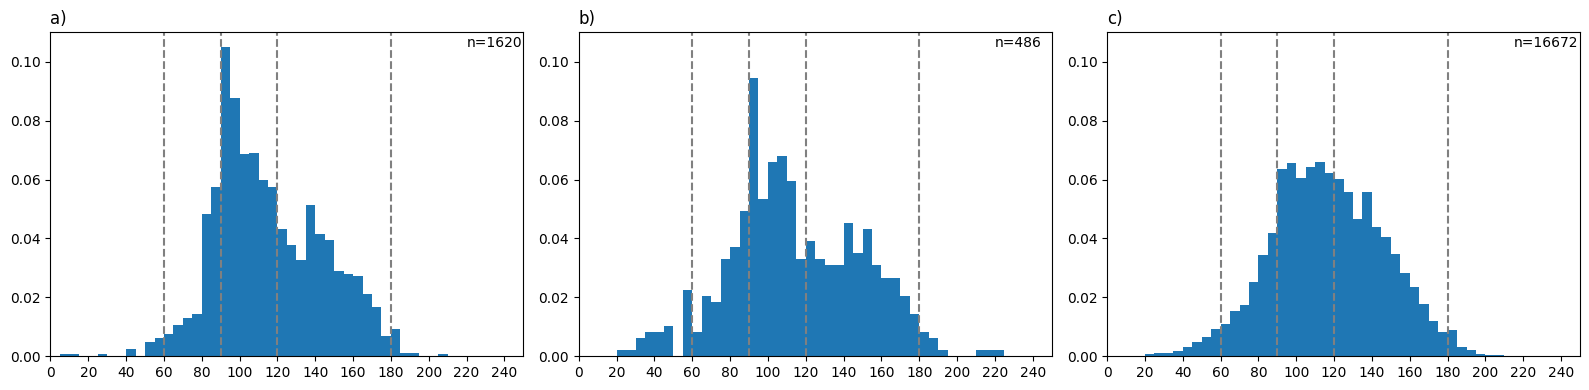

In [27]:
fig, ax = plt.subplots(1,3,figsize=(16,4),layout='tight')

# first two histograms of orthogonal regions
for idx, row in ortho_intersection_df.iterrows():
    angles = row['angles']
    ax[idx].hist(angles,bins=50,range=(0,250),align='mid',weights=np.ones(len(angles)) / len(angles))
    ax[idx].set_xticks(np.arange(0,250,20))
    ax[idx].set_ylim(0,0.11)
    ax[idx].set_xlim(0,250)
    ax[idx].vlines([60,90,120,180],0,1,colors='gray',linestyles='dashed')
    ax[idx].text(220,0.105,f'n={len(angles)}')

#final histogram of full field
ax[2].hist(intersection_angles,bins=50,range=(0,250),align='mid',weights=np.ones(len(intersection_angles)) / len(intersection_angles))
ax[2].set_xticks(np.arange(0,250,20))
ax[2].set_ylim(0,0.11)
ax[2].set_xlim(0,250)
ax[2].vlines([60,90,120,180],0,1,colors='gray',linestyles='dashed')
ax[2].text(215,0.105,f'n={len(intersection_angles)}')

ax[0].set_title('a)',loc='left')
ax[1].set_title('b)',loc='left')
ax[2].set_title('c)',loc='left')

fig.savefig('FIGURES/intersectionangle_hitsograms.png')

In [28]:
def bin_data(data,min_edge,max_edge,step):
    '''Function to bin data. Returns dictionary of data binned with the key giving the lower bound on the bin '''
    bin_edges = np.arange(min_edge,max_edge,step)
    bins = {}
    for i in range(len(bin_edges)-1): # create
        bins[bin_edges[i]] = []

    for a in data:
        for i in range(len(bin_edges)):
            if a < bin_edges[i]:
                bins[bin_edges[i-1]].append(a)
                break
    return bins

In [29]:
# get 
binned_angles = pd.Series(index=grid_df.index,dtype='object')
for idx, row in intersection_df.iterrows():
    binned_angles[idx] = bin_data(row['angles'],0,360,10)


## Randomness of Polygon arrangment
Calculate ANN for each segment. Use Monte Carlo (1000 iterations) for each box and calculate p-value.

In [30]:
# Average neighbour distances:
def average_neighbour_distances(intersections):
    neighbour_distances = {}

    for i in range(len(intersections)):
        p = intersections[i]
        distances = [] #list of distances to all other points
        for j in range(len(intersections)): #calculate distance to all other points
            n = intersections[j]
            distances.append(p.distance(n))
        distances = sorted(distances) # sort by distance
        for k in range(0,len(distances)):
            if (k in neighbour_distances.keys()) == True:
                neighbour_distances[k].append(distances[k])
            else:
                neighbour_distances[k] = [distances[k]]

    for i in neighbour_distances:
        neighbour_distances[i] = np.average(neighbour_distances[i])
    return neighbour_distances

In [31]:
ann_Series = pd.Series(index=grid_df.index,dtype='float64')

for idx, row in grid_df.iterrows():
    neighbour_d = average_neighbour_distances(row['intersections'])
    ann_Series[idx] = neighbour_d

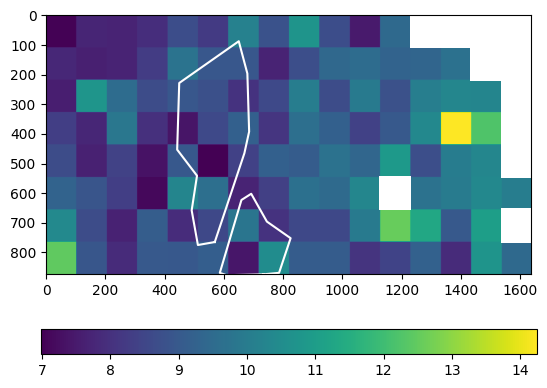

In [32]:
nearest_arr = np.zeros_like(dem)
for idx in ann_Series.index:
    xmin,ymin,xmax,ymax = grid_df.loc[idx]['box'].bounds
    if len(ann_Series[idx])>20: 
        nearest_arr[int(ymin):int(ymax),int(xmin):int(xmax)] = ann_Series[idx][1]
    else:
        nearest_arr[int(ymin):int(ymax),int(xmin):int(xmax)] = np.nan

plt.imshow(nearest_arr,origin='upper')
for p in observed_orthogonal:
    x,y = p.boundary.coords.xy
    plt.plot(x,y,c='white')
plt.colorbar(location='bottom')
plt.ylim(dem.shape[0]);

## Nice Figures

## Stats box plots for whole region and orthogonal sections

In [33]:
ortho_stats1 = calculate_stats(orth_polygons_df.iloc[0]['polygons'])
ortho_stats2 = calculate_stats(orth_polygons_df.iloc[1]['polygons'])

In [34]:
ortho_stats2.columns

Index(['Area_m2', 'Width_m', 'Length_m', 'Aspect_Ratio', 'Size_m',
       'Perimeter_m', 'Thickness_ratio'],
      dtype='object')

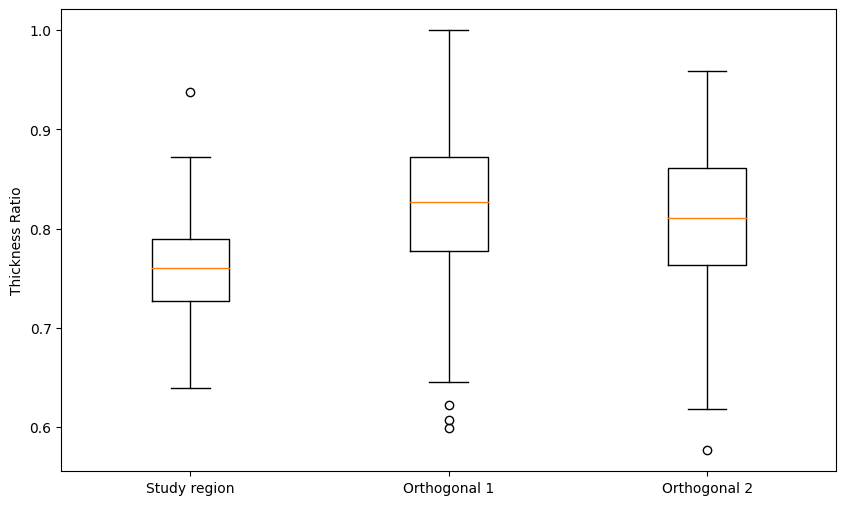

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
stat ='Thickness_ratio'

ax.boxplot([df[stat],ortho_stats1[stat],ortho_stats2[stat]],labels=['Study region','Orthogonal 1', 'Orthogonal 2'])
ax.set_ylabel('Thickness Ratio')

fig.savefig('FIGURES/Study_TR.png')

### Segmented Thickness ratio map

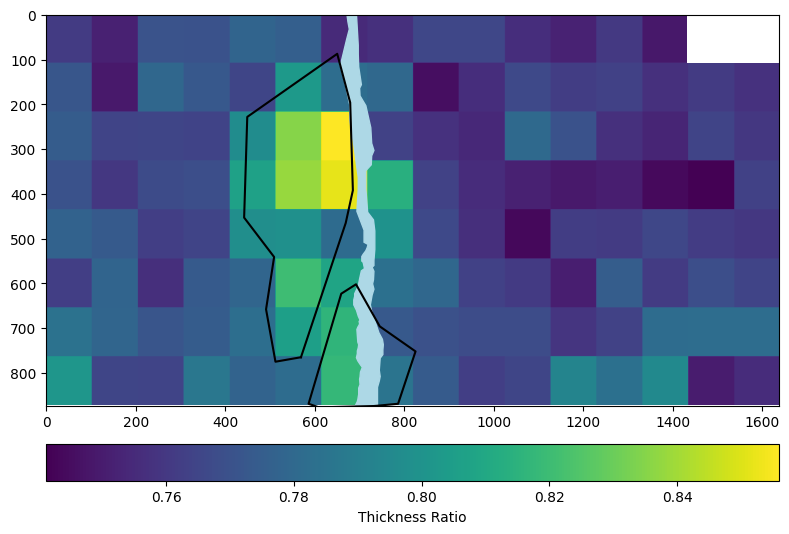

In [140]:
fig, ax = plt.subplots(1,1, figsize=(8,8),layout='tight')
im = ax.imshow(thick_arr,cmap='viridis',origin='lower')

x,y = stream.boundary.coords.xy
ax.fill(x,y,color='lightblue')

for p in observed_orthogonal:
    x,y = p.boundary.coords.xy
    ax.plot(x,y,c='black')

ax.set_ylim(dem.shape[0],0)
fig.colorbar(im,location='bottom',pad=0.05,label='Thickness Ratio')

fig.savefig('FIGURES/segmented_TR.png')